# Analysis of excitonic states

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import sys
sys.path.insert(0,'../')
import Routine as R
outputpath = 'linear-response/'

Autosave disabled


We read the coupling matrix and dipoles (with the highest given number of virtual orbitals)

In [2]:
nVirtMax = 303
%cd $outputpath
dpath = 'log/TDDFT-Results/transition_dipoles_'+str(nVirtMax)+'.txt'
dipoles = np.loadtxt(dpath)
cpath = 'log/TDDFT-Results/coupling_matrix_'+str(nVirtMax)+'.txt'
Cmat = np.loadtxt(cpath)
%cd ..
Cmat.shape

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


(3030, 3030)

We set the number of empty and virtual states and build the C submatrix with the chosen values of nalpha

In [3]:
numOrb = 5
nalpha = [32,64,128,nVirtMax]

We compute the eigenvalues and vectors of C_ext (linalg.eigh gives the eigenvectors in the transpose form so we peform an explicit transpose to the vectors sorted as row vectors)

In [4]:
eigenproblems = {}
for na in nalpha:
    C_ext,dipoles_ext=R.extract_subset([numOrb],[nVirtMax],Cmat,dipoles,[na])
    print C_ext.shape
    E2,C_E2 = np.linalg.eigh(C_ext)
    C_E2 = C_E2.T
    eigenproblems[na] = (C_ext,E2,C_E2)

(320, 320)
(640, 640)
(1280, 1280)
(3030, 3030)


In [5]:
for na in nalpha:
    C_ext = eigenproblems[na][0]
    E2 = eigenproblems[na][1]
    C_E2 = eigenproblems[na][2]
    for ind,e in enumerate(E2):
        isok = np.allclose(C_ext.dot(C_E2[ind]),e*C_E2[ind],atol=1.e-12)
        if not isok: print('Eigenvalue',ind,'is false')
print('Validation terminated')

Validation terminated


We choose a set of excitations and compute the contribution of the virtual states in the corresponding eigenstates of C_ext

In [78]:
exc = [0,1,2,3] # [i for i in range(20)] # select the list of excitation index

In [79]:
reload(R)
weightP,weightAlpha = R.weight(numOrb,nalpha,exc,eigenproblems)

nalpha =  32

Excitation number : 1  energy =  7.36721935915
  ******* occupied state contribution ********
  occupied state : 5  weight =  0.99974275101
  1 - sumOverThreshold p =  2.572e-04
  ******* virtual state contribution *********
  virtual state  : 2  weight =  0.999495503353
  1 - sumOverThreshold alpha =  5.045e-04

Excitation number : 2  energy =  7.36722034469
  ******* occupied state contribution ********
  occupied state : 5  weight =  0.999744978956
  1 - sumOverThreshold p =  2.550e-04
  ******* virtual state contribution *********
  virtual state  : 1  weight =  0.999496672574
  1 - sumOverThreshold alpha =  5.033e-04

Excitation number : 3  energy =  7.44747757742
  ******* occupied state contribution ********
  occupied state : 3  weight =  0.499112669575
  occupied state : 4  weight =  0.499129695311
  1 - sumOverThreshold p =  1.758e-03
  ******* virtual state contribution *********
  virtual state  : 1  weight =  0.497387563155
  virtual state  : 2  weight =  0.4

We build a dictionary that collects all the excitations. These quantities contain, for each value of the number of virtual orbitals, the eigenproblems data and the transition data. This latter dictionary is parametreized in term of the
findTransition parameter and contains the weights (p and alpha) and the index of the eigenvalue

In [80]:
excitations = {}
for a,na in enumerate(nalpha):
    transitions = {}
    for i in range(len(exc)):
        tr = R.findTransition(weightP[a][i],weightAlpha[a][i])
        transitions[tr] = {'weightP' : weightP[a][i], 'weightAlpha' : weightAlpha[a][i], 'ind' : i, 'eng' : 27.211*np.sqrt(eigenproblems[na][1][i]) }
    excitations[na] = {'Cmat' : eigenproblems[na][0], 'E2': eigenproblems[na][1], 'C_E2' : eigenproblems[na][2], 'transitions' : transitions}

In [81]:
excitations = {}
for a,na in enumerate(nalpha):
    transitions = {}
    for i in range(len(exc)):
        tr = R.findTransition(weightP[a][i],weightAlpha[a][i])
        ind=0
        while tr+'-'+str(ind) in transitions:
            ind+=1
        tr=tr + '-' + str(ind)
        transitions[tr] = {'weightP' : weightP[a][i], 'weightAlpha' : weightAlpha[a][i], 'ind' : i, 'eng' : 27.211*np.sqrt(eigenproblems[na][1][i]) }
    excitations[na] = {'Cmat' : eigenproblems[na][0], 'E2': eigenproblems[na][1], 'C_E2' : eigenproblems[na][2], 'transitions' : transitions}

In [82]:
# example
excitations[128]['transitions']

{'34to12-0': {'eng': 7.3458728393126993,
  'ind': 0,
  'weightAlpha': array([  4.95797868e-01,   4.95876199e-01,   9.60896554e-04,
           5.89525412e-04,   6.83512300e-08,   4.69043231e-07,
           2.07457129e-05,   4.09113825e-11,   4.72847262e-11,
           1.88998919e-03,   1.89106648e-03,   4.14710557e-06,
           6.62336381e-07,   6.49610259e-07,   7.12859673e-07,
           7.21294260e-07,   4.37962098e-10,   2.90438807e-08,
           2.24937036e-04,   1.85832696e-04,   3.70817168e-07,
           1.31461700e-06,   3.11321739e-05,   5.06444538e-09,
           2.55948158e-05,   2.58348363e-05,   1.83948877e-08,
           6.10977020e-08,   6.28817744e-08,   6.38800401e-05,
           2.34810874e-09,   4.68910400e-09,   4.44605315e-08,
           1.78957921e-13,   7.45611191e-04,   7.48471531e-04,
           2.12119375e-05,   2.40054568e-07,   2.30306974e-07,
           1.22129709e-07,   1.24425692e-07,   6.66250871e-10,
           5.32429930e-10,   2.73727191e-06,   7.2

## Data analysis

We define some tools to analyze the properties of the first excitations. In particular, we want to be able to understand the following points:
* unambigous characterization of the excitations and degeneracy
* dependence of the energy of the excitation with respect to the number of virtual orbitals
* analysis of the coefficients of the expansion of the eigenvectors and appearence of new contributions in function
  of the number of virtual orbitals
* properties of convergence of the sumBelowThreshold coefficients in function of the number of virtual orbitals

In [83]:
# val += [ v['eng'] for  v in excitations[na]['transitions'].values() ]
val = []
for na in nalpha:
    for k in excitations[na]['transitions']:
        val.append([na,excitations[na]['transitions'][k]['eng'],k])
val    

[[32, 7.367219359154765, '5to2-0'],
 [32, 7.3672203446853626, '5to1-0'],
 [32, 7.447477577424376, '34to12-0'],
 [32, 8.4665084965352566, '34to12-1'],
 [64, 7.3628515752171113, '5to2-0'],
 [64, 7.3628480509030094, '5to1-0'],
 [64, 7.4046999548546824, '34to12-0'],
 [64, 8.4576112196257931, '34to12-1'],
 [128, 7.3546379392860457, '5to2-0'],
 [128, 7.3546311988156896, '5to1-0'],
 [128, 7.3458728393126993, '34to12-0'],
 [128, 8.4466774763952088, '34to12-1'],
 [303, 7.3437862525955486, '5to2-0'],
 [303, 7.3437829021443095, '5to1-0'],
 [303, 7.3080917330483448, '34to12-0'],
 [303, 8.4362382431192238, '34to12-1']]

In [84]:
%matplotlib auto
for v in val:
    plt.scatter(v[0],v[1],label=v[2])
    plt.annotate(v[2],xy=(v[0],v[1]))
#plt.legend(loc=(1.05,0))
plt.show()

Using matplotlib backend: TkAgg


To know which transition are included in the exc list we can compute

In [10]:
transitionVal = []
for na in nalpha:
    for key in excitations[na]['transitions']:
        transitionVal.append(key)
transitionVal = list(set(transitionVal))
transitionVal

['5to2', '34to12', '5to1']

selected transition :  5to2


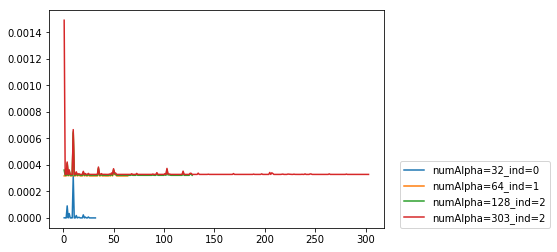

In [14]:
%matplotlib inline
tr = transitionVal[0]
print 'selected transition : ', tr
offset = 0.0
for na in nalpha:
    if tr in excitations[na]['transitions'].keys():
        alpha = [i for i in range(1,na+1)]
        wAlpha = R.weightCut(excitations[na]['transitions'][tr]['weightAlpha'])
        ind = str(excitations[na]['transitions'][tr]['ind'])
        plt.plot(alpha,offset + wAlpha,label = 'numAlpha='+str(na) + '_ind='+ind)
        offset = max(wAlpha)
plt.legend(loc = (1.05,0))        
plt.show()